# UMAP Tutorial

This tutorial includes:
- Details on what's under the hood of Uniform Manifold Approximation and Projection (UMAP) and how to use it
- A comparison of UMAP, t-SNE, and PCA through the MNIST Handwritten Digits dataset
- Additional plotting details that may or may not be useful/applicable

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import cm
import seaborn as sns
from time import time
import scipy.stats as stats
import math
import random
from matplotlib import offsetbox
%matplotlib inline

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.datasets import fetch_openml
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)

import umap


UMAP is an unsupervised, non-linear machine learning technique suited for data exploration and visualization through dimensionality reduction. This method maintains pairwise distances (local similarities) along with global data structure.

General steps describing what's under the hood:

1. Determine high-dimensional probabilities - center a Gaussian probability distribution tent over each point in high-dimensional space and calculate pairwise probabilities. What's the likelihood something will be neighbors in a high dimensions?

2. Determine low-dimensional probabilities - repeat step \#1 for low-dimensional probabilities by centering a probability distribution with heavy tails over each point in high-dimensional space and calculate pairwise probabilities. 

3. Measure the difference between high-dimensional and low-dimensional mappings and minimize a cost function - use stochastic gradient descent to minimize a cross-entropy cost function. What dimensionality reduction best represents both high and low dimensional mappings?

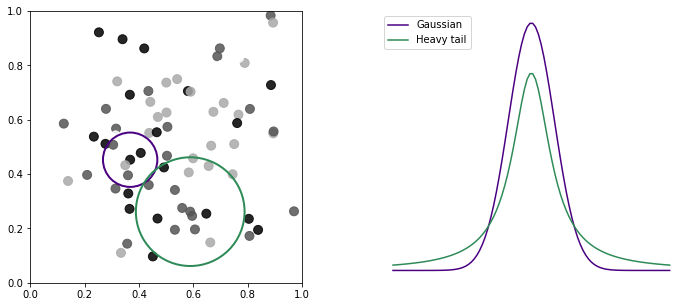

In [2]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

## Show plot with random dots and circle them to show how a gaussian tent would look
#https://www.w3resource.com/graphics/matplotlib/scatter/matplotlib-scatter-exercise-3.php
#https://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot
no_of_balls = 100
x = [random.triangular() for i in range(no_of_balls)]
y = [random.gauss(0.5, 0.25) for i in range(no_of_balls)]
colors = [random.randint(1, 4) for i in range(no_of_balls)]

circle1 = plt.Circle((x[1], y[1]), 0.1, color='indigo', linewidth=2, fill=False)
circle2 = plt.Circle((x[5], y[5]), 0.2, color='seagreen', linewidth=2, fill=False)

ax1.scatter(x, y, s=80, c=colors, cmap='gray',alpha=0.85)
ax1.axis([0.0, 1.0, 0.0, 1.0])
ax1.set_aspect('equal', adjustable='box')

ax1.add_patch(circle1)
ax1.add_patch(circle2)

## Show probability distributions
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 6*sigma, mu + 6*sigma, 100)
ax2.plot(x, stats.norm.pdf(x, mu, sigma),label = 'Gaussian',c='indigo')
ax2.plot(x, stats.cauchy.pdf(x),label = 'Heavy tail',c='seagreen')
ax2.axis('off')
ax2.legend(loc='upper left')

plt.show()

## MNIST Handwritten Digits - UMAP, PCA, t-SNE

This example will go through differences between:
- Principal Component Analysis (PCA) [1901, Pearson & 1933, Hotelling]
- t-Distributed Stochastic Neighbor Embedding (t-SNE) [2008, van der Maaten]
- Uniform Manifold Approximation and Projection (UMAP) [2018, McInnes] 

We will compare how the digits dataset is reduced using each technique.

### Step 1: Load the digits dataset

In [3]:
digits = load_digits(n_class=10) ## Use this dataset if you want this to be faster
#digits = fetch_openml("mnist_784", version=1)

X = digits.data
y = digits.target.astype(int)
#color = digits.target.astype(int)
n_samples, n_features = X.shape
# n_neighbors = 30

# # Plot images of the digits
# plt.figure(figsize=(6,6), dpi= 100, facecolor='w', edgecolor='k')  
# n_img_per_row = 20
# img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
# for i in range(n_img_per_row):
#     ix = 10 * i + 1
#     for j in range(n_img_per_row):
#         iy = 10 * j + 1
#         img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))
# plt.imshow(img, cmap=plt.cm.binary)
# plt.xticks([])
# plt.yticks([])

The function below helps visualize where digits are in the projections (you don't need to duplicate this in your own code, but it's nice for the tutorial.)

In [4]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(6,6), dpi= 100, facecolor='w', edgecolor='k')  
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Spectral(y[i] / 9.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

### Step 2: Reduce your data!

This step is surprisingly simple with Python packages. It is incredibly easy to get a projection of your data in a reduced dimension. However, it is important to understand what is happening in the process (*not magic!*)

#### Principal Component Analysis (PCA)

In this example I am using PCA, but note that there are other linear reduction methods (for example TruncatedSVD is often used for sparse data.)

**The following line performs the entire reduction and transforms the data (*X* is the digits dataset)**

In [5]:
X_pca = decomposition.PCA(n_components=2).fit_transform(X) ## can replace PCA with TruncatedSVD for sparse datasets

**Now we can visualize the reduced data. Plot the two reduced dimensions and color code based on the target value, *y*, which in this case is the digit label**

*Note how PCA did not separate different digits very well.*

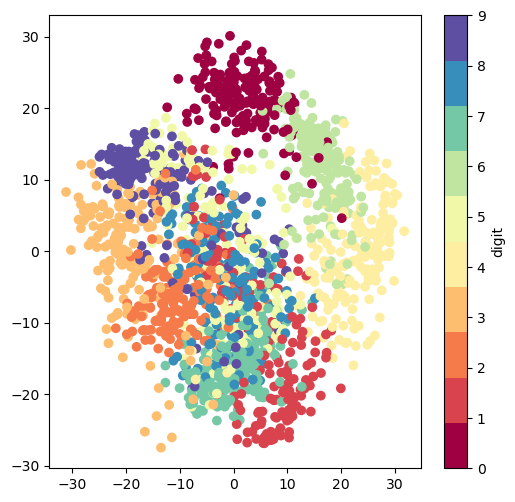

In [6]:
cmap = cm.get_cmap('Spectral',10)

plt.figure(figsize=(6,6), dpi= 100, facecolor='w', edgecolor='k')  
plt.scatter(X_pca[:,0],X_pca[:,1], c = y, cmap=cmap)
plt.colorbar(label='digit')

Using the function we defined earlier, we have another visualization of where each digit is.

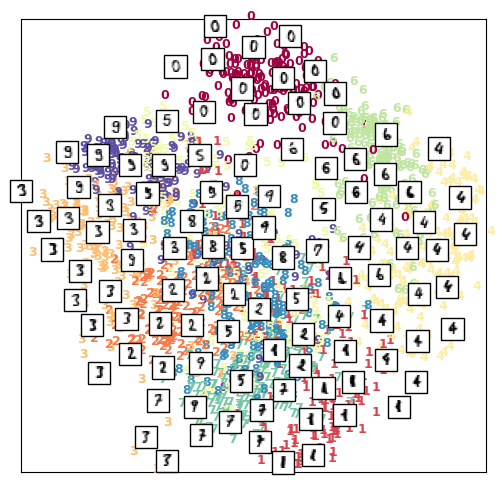

In [7]:
plot_embedding(X_pca,"")

#### t-Distributed Stochastic Neighbor Embedding (t-SNE)

PCA was not the best tool for separating digits into groups. Next we will try t-SNE which is a non-linear reduction method that was introduced in 2008 by van der Maaten. This algorithm uses two sets of high-dimensional pairwise probabilities to find a reduced dimensionality mapping.

**Just like PCA, this is super easy to implement.** But there are many hyperparameters so when using this, you have to make sure the reduction is tailored to your data type and size. 

In [8]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)

/opt/conda/envs/DNASquared/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/conda/envs/DNASquared/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


**Now plot the reduced dimensions.**

*Note how this worked way better for separating digits than PCA.*

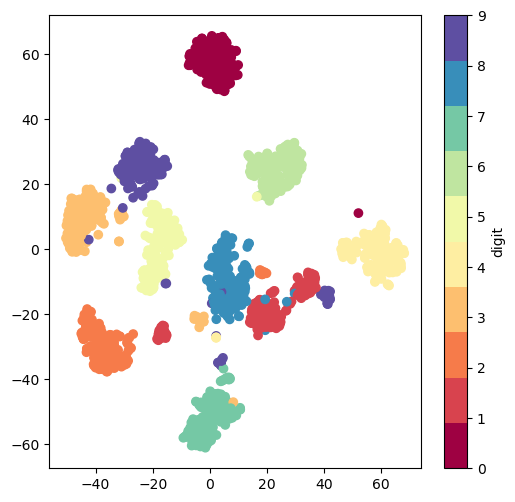

In [9]:
cmap = cm.get_cmap('Spectral',10)

plt.figure(figsize=(6,6), dpi= 100, facecolor='w', edgecolor='k')  
plt.scatter(X_tsne[:,0],X_tsne[:,1], c = y, cmap=cmap)
plt.colorbar(label='digit')

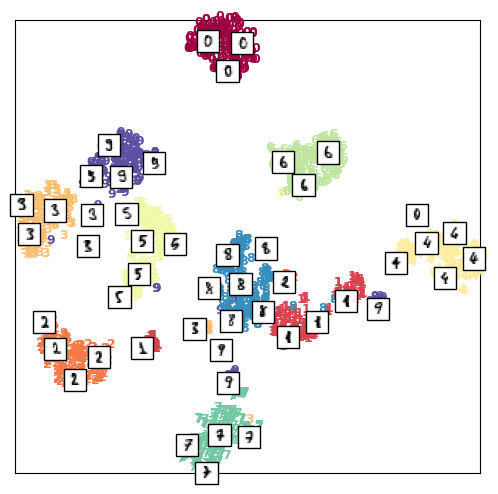

In [10]:
plot_embedding(X_tsne,"")

#### Uniform Manifold Approximation and Projection (UMAP)

Another non-linear reduction technique which this author considers to be *significantly better* (it's newer and works similarly, but its reduction method maintains both local and global data structure.)

Introduced by McInnes in 2018 - UMAP advances on UMAP by performing faster, using less memory, and preserving more high dimensional data structure. 

Key changes from t-SNE:
1. No normalization between probability calculations (faster)
2. Stochastic Gradient Descent rather than Gradient Descent (faster and less memory)
3. No need for pre-reduction. Keeps track of local connectivity.
4. Cross-Entropy cost function rather than Kullback Liebler divergence (better preservation of global data structure)

**Once again, this is only a couple lines of code to implement.** But there are many hyperparameters so when using this, you have to make sure the reduction is tailored to your data type and size. 

In [11]:
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X)

Now plot this.

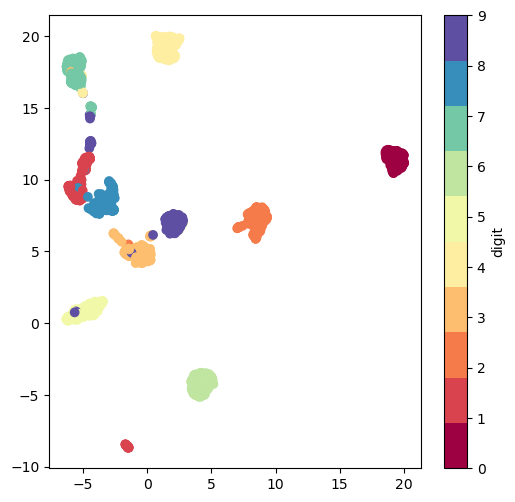

In [12]:
cmap = cm.get_cmap('Spectral',10)

plt.figure(figsize=(6,6), dpi= 100, facecolor='w', edgecolor='k')  
plt.scatter(X_umap[:,0],X_umap[:,1], c = y, cmap=cmap)
plt.colorbar(label='digit')

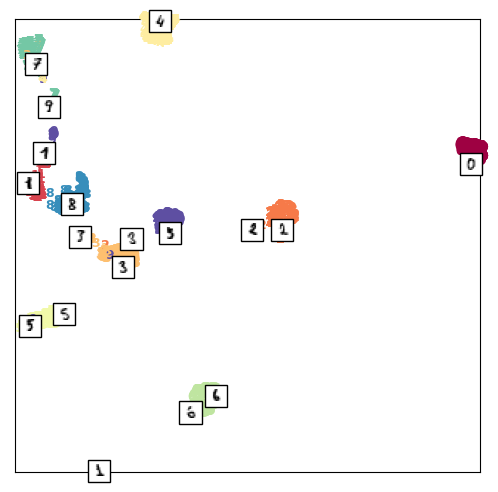

In [13]:
plot_embedding(X_umap,"")

## Side by Side Comparison

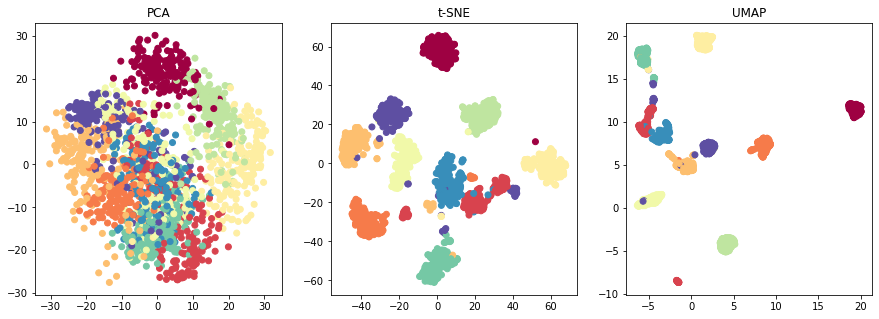

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

cmap = cm.get_cmap('Spectral',10)

ax1.scatter(X_pca[:,0],X_pca[:,1], c = y, cmap=cmap)
ax1.set_title("PCA")
ax2.scatter(X_tsne[:,0],X_tsne[:,1], c = y, cmap=cmap)
ax2.set_title("t-SNE")
ax3.scatter(X_umap[:,0],X_umap[:,1], c = y, cmap=cmap)
ax3.set_title("UMAP")

plt.show()

## UMAP for Clustering

Using UMAP enhanced clustering for this: https://umap-learn.readthedocs.io/en/latest/clustering.html

Notably, we start with different reduction hyperparameters when we are using this for clustering vs. visualization. 

In [15]:
## if you want a more interesting clustering with a larger dataset, uncomment this line. Note: it will take much longer to run.

# digits = fetch_openml("mnist_784", version=1)

In [16]:
clusterable_umap = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(digits.data)

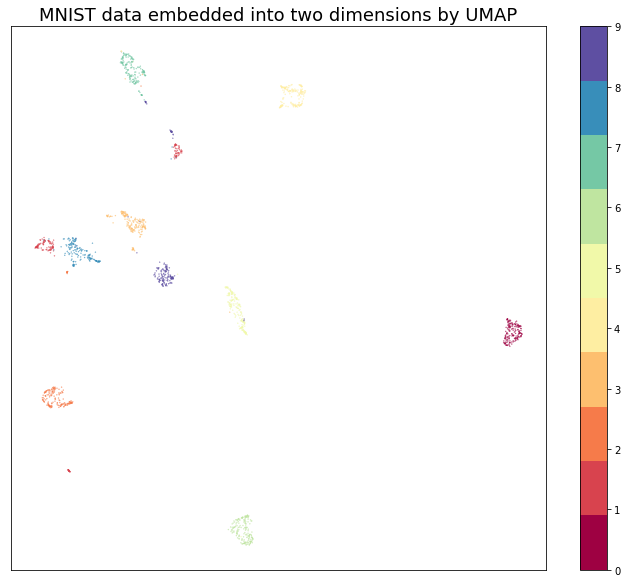

In [17]:
cmap = cm.get_cmap('Spectral',10)

fig, ax = plt.subplots(figsize=(12, 10))
color = digits.target.astype(int)
plt.scatter(clusterable_umap[:, 0], clusterable_umap[:, 1], c=color, cmap=cmap, s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by UMAP", fontsize=18)
plt.colorbar()

plt.show()

# Additional Visualization Techniques

So far we have colored plots by target digit values. This makes the most sense for the digits dataset. Let's load the Iris dataset to show how other color overlays can provide data insights.

First we will load the Iris dataset and perform UMAP reduction then plot by flower species type.

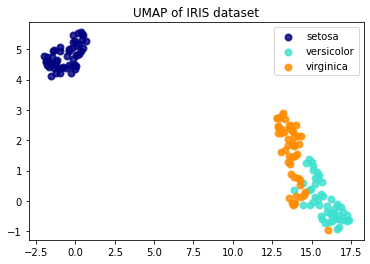

In [25]:
iris = datasets.load_iris()

iris_X = iris.data
iris_y = iris.target
target_names = iris.target_names

reducer = umap.UMAP(n_neighbors=100,random_state=10)
embedding = reducer.fit_transform(iris_X)

colors = ['navy', 'turquoise', 'darkorange']

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(embedding[iris_y == i, 0], embedding[iris_y == i, 1], color=color, alpha=.8, linewidth=2,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('UMAP of IRIS dataset')

plt.show()

But what if we want to know other things about the flowers, such as characteristics about the petals and sepals?

To do this we are going to generate plots with color overlays for various flower characteristic values. First we need to pull those values from the dataset.

In [31]:
## There are many ways to do this. 
## I commonly use lists to overlay colormaps on my scatterplots so that is what I have done here.
def Extract(lst,i):
    return [item[i] for item in lst]

#'sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)
sepal_len = Extract(iris["data"],0)
sepal_wid = Extract(iris["data"],1)
petal_len = Extract(iris["data"],2)
petal_wid = Extract(iris["data"],3)

*Et voila!* We can use the lists of characteristics as the color field of our UMAP plots. Note how different flower types have different characteristic values. In this case, we can now see *why* versicolor and virginica species are classified as similar to one another.

Note: In this case, the data used in the color overlays are also part of the feature vectors so you would expect these plots to show strong correlations. However, any value can be overlaid on the plot (silly example we don't have the data for: if you ranked each flower's beauty on a scale of 1 to 10 you could overlay that on this plot to see if there are correlations between beauty and species/petal dimensions/sepal dimensions).

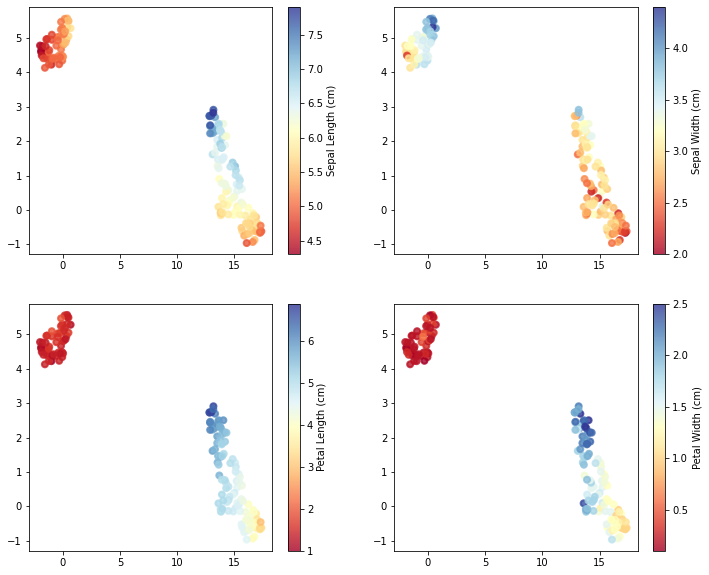

In [30]:
cm = plt.cm.get_cmap('RdYlBu')

fig, axs = plt.subplots(2, 2)

lw=2

fig.set_size_inches(12, 10)
# fig.suptitle('UMAP Projection', fontsize=20)

pcm1 = axs[0, 0].scatter(embedding[:, 0], embedding[:, 1], c=sepal_len, alpha=.8, lw=lw, cmap=cm)
fig.colorbar(pcm1, label="Sepal Length (cm)", ax = axs[0,0])

pcm2 = axs[0, 1].scatter(embedding[:, 0], embedding[:, 1], c=sepal_wid, alpha=.8, lw=lw, cmap=cm)
fig.colorbar(pcm2, label="Sepal Width (cm)", ax = axs[0,1])

pcm3 = axs[1, 0].scatter(embedding[:, 0], embedding[:, 1], c=petal_len, alpha=.8, lw=lw, cmap=cm)
fig.colorbar(pcm3, label="Petal Length (cm)", ax = axs[1,0])

pcm4 = axs[1, 1].scatter(embedding[:, 0], embedding[:, 1], c=petal_wid, alpha=.8, lw=lw, cmap=cm)
fig.colorbar(pcm4, label="Petal Width (cm)", ax = axs[1,1]);